In [1]:
import torch 
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 150
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
#hyperparameters

batch_size = 100
input_size = 7
lstm_hidden_size = 16  
linear_hidden_size_1 = 32
linear_hidden_size_2 = 16
output_size = 6
seq_len = 33
dropout = 0
learning_rate = 0.0001
num_epochs = 200 

#seed = np.random.randint(10000000, size=1).item() #random seed

In [3]:
#dataset preparation


#data importing
df = pd.read_csv('All vars cleaned - no solar rad.csv')
df.Date = pd.to_datetime(df.Date, format = '%m/%d/%Y')
df = df.set_index('Date')

#data scaling
df_scaled = (df - df.mean())/ df.std()
df_scaled.head()

#storing mean and std
df_np_mean = df.mean().to_numpy()
df_np_std = df.std().to_numpy()

#dropping date column
df_scaled.reset_index(inplace = True)
df_scaled = df_scaled.drop('Date', 1)

#creating sequences
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences): break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, 0:7], sequences[i:end_ix, 7:14]
        X.append(seq_x)
        y.append(seq_y)
    return X, y

array = df_scaled.iloc[:, :].values
print ('shape of the datset array: {}'.format(array.shape))
X, y = split_sequences(array, seq_len)
X_array = np.array(X, dtype = np.float32)
y_array = np.array(y)
y_array = y_array[:, -1, :]
print ('sequenced X array shape: {}'.format(X_array.shape))
print ('sequenced y array shape: {}'.format(y_array.shape))

shape of the datset array: (2189, 13)
sequenced X array shape: (2157, 33, 7)
sequenced y array shape: (2157, 6)


In [4]:
#making dataset and subsets

class AirMeteoroDataset(Dataset):
    def __init__(self):
        self.len = X_array.shape[0]
        self.X_data = torch.from_numpy(X_array)
        self.y_data = torch.from_numpy(y_array)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return self.len
    
dataset = AirMeteoroDataset()


#Dataset split
train_index = list(range(0,1454))
val_index = list(range(1454,1819))
test_index = list(range(1819,2184))

train_set = torch.utils.data.Subset(dataset, train_index)
val_set = torch.utils.data.Subset(dataset, val_index)
test_set = torch.utils.data.Subset(dataset, test_index)

In [5]:
#making mini-batches for training set

train_loader = DataLoader(dataset = train_set,
                          batch_size = batch_size,
                          drop_last = True,
                          shuffle = False)

In [6]:
#output mask preparation

df_mask = pd.read_excel('maked outputs - no solar rad.xlsx')
df_mask.head()

mask_array = df_mask.iloc[:, :].values
#print(mask_array.shape)

#sequencing
def mask_sequence(sequence, n_steps):
    y = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_iy = i + n_steps
        # check if we are beyond the dataset
        if end_iy > len(sequence): break
        # gather input and output parts of the pattern
        seq_y = sequence[i:end_iy, 0:6]
        y.append(seq_y)
    return y

mask_list = mask_sequence(mask_array, seq_len)
mask_array = np.array(mask_list)
mask_array= mask_array[:, -1, :]
#print(mask_array)

class maskDataset(Dataset):
    def __init__(self):
        self.len = mask_array.shape
        self.mask_tensor = torch.from_numpy(mask_array)

    def __getitem__(self, index):
        return self.mask_tensor[index]

    def __len__(self):
        return self.len
    
    
masked_data = maskDataset()

mask_train_set= torch.utils.data.Subset(masked_data, train_index)
mask_val_set = torch.utils.data.Subset(masked_data, val_index)
mask_test_set = torch.utils.data.Subset(masked_data, test_index)

mask_loader = DataLoader(dataset = mask_train_set,
                         batch_size = batch_size,
                         drop_last = True,
                         shuffle = False)

In [7]:
#validation and test data


X_val = torch.empty(0, seq_len, input_size).float().cuda()
y_val = torch.empty(0, output_size).float().cuda()

for i, (X_data, y_data) in enumerate(val_set):
    X_data = X_data.float().reshape(1, seq_len, input_size).cuda()
    X_val = torch.cat((X_val, X_data), 0)
    
    y_data = y_data.float().reshape(1, output_size).cuda()
    y_val = torch.cat((y_val, y_data), 0)
    
#print(X_val.shape)
#print(y_val.shape)

mask_val = torch.empty(0, output_size).float().cuda()

for i, y_data in enumerate(mask_val_set):
    y_data = y_data.float().reshape(1, output_size).cuda()
    mask_val = torch.cat((mask_val, y_data), 0)
    
#print(mask_val.shape)


X_test = torch.empty(0, seq_len, input_size).float().cuda()
y_test = torch.empty(0, output_size).float().cuda()

for i, (X_data, y_data) in enumerate(test_set):
    X_data = X_data.float().reshape(1, seq_len, input_size).cuda()
    X_test = torch.cat((X_test, X_data), 0)
    
    y_data = y_data.float().reshape(1, output_size).cuda()
    y_test = torch.cat((y_test, y_data), 0)
    
#print(X_test.shape)
#print(y_test.shape)


mask_test = torch.empty(0, output_size).float().cuda()

for i, y_data in enumerate(mask_test_set):
    y_data = y_data.float().reshape(1, output_size).cuda()
    mask_test = torch.cat((mask_test, y_data), 0)
    
#print(mask_test.shape)

torch.Size([365, 33, 7])
torch.Size([365, 6])
torch.Size([365, 6])
torch.Size([338, 33, 7])
torch.Size([338, 6])
torch.Size([338, 6])


In [8]:
class Model(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, linear_hidden_size_1, linear_hidden_size_2, output_size, dropout):
        super(Model, self).__init__()
        self.input_size = input_size
        self.lstm_hidden_size = lstm_hidden_size
        self.output_size = output_size
        self.linear_hidden_size_1 = linear_hidden_size_1
        self.linear_hidden_size_2 = linear_hidden_size_2
        
        self.batchnorm1 = nn.BatchNorm1d(num_features = linear_hidden_size_1)
        self.batchnorm2 = nn.BatchNorm1d(num_features = linear_hidden_size_2)
        
        self.dropout_lstm = 0
        self.relu = nn.ReLU()
        self.output_size = output_size
        self.dropout_linear = nn.Dropout(p = dropout)
        
        self.lstm = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.lstm_hidden_size,
            dropout = self.dropout_lstm,
            batch_first = True
        )
        
        self.linear_1 = nn.Linear(self.lstm_hidden_size, self.linear_hidden_size_1)
        self.linear_2 = nn.Linear(self.linear_hidden_size_1, self.linear_hidden_size_2)
        self.linear_3 = nn.Linear(self.linear_hidden_size_2, self.output_size)
    
        
    def forward(self, sequences):
        lstm_out, _ = self.lstm(sequences)
        
        z1 = self.linear_1(lstm_out[:, -1, :])
        a1 = self.dropout_linear(self.relu(self.batchnorm1(z1)))
        
        z2 = self.linear_2(a1)
        a2 = self.dropout_linear(self.relu(self.batchnorm2(z2)))
        
        y_pred = self.linear_3(a2)
        return y_pred

In [9]:
class modsmoothl1(nn.SmoothL1Loss):
    def __init__(self, size_average=None, reduce=None, reduction = 'none'):
        super(modsmoothl1, self).__init__(size_average, reduce, reduction)
        
    def forward(self, observed, predicted, mask):
        predicted_masked = mask*predicted
        loss = F.smooth_l1_loss(observed, predicted_masked, reduction=self.reduction)
        avg_loss = torch.sum(loss)/torch.sum(mask)
        return avg_loss

In [10]:
forecast_model = Model(input_size,
                   lstm_hidden_size,
                   linear_hidden_size_1,
                   linear_hidden_size_2,
                   output_size,
                   dropout).cuda().float()

criterion = modsmoothl1()
optimizer = torch.optim.Adam(forecast_model.parameters(), lr = learning_rate)

Train loss after Epoch [50/200]: 0.323823
Train loss after Epoch [100/200]: 0.303136
Train loss after Epoch [150/200]: 0.293643
Train loss after Epoch [200/200]: 0.287511


Text(0, 0.5, 'Loss')

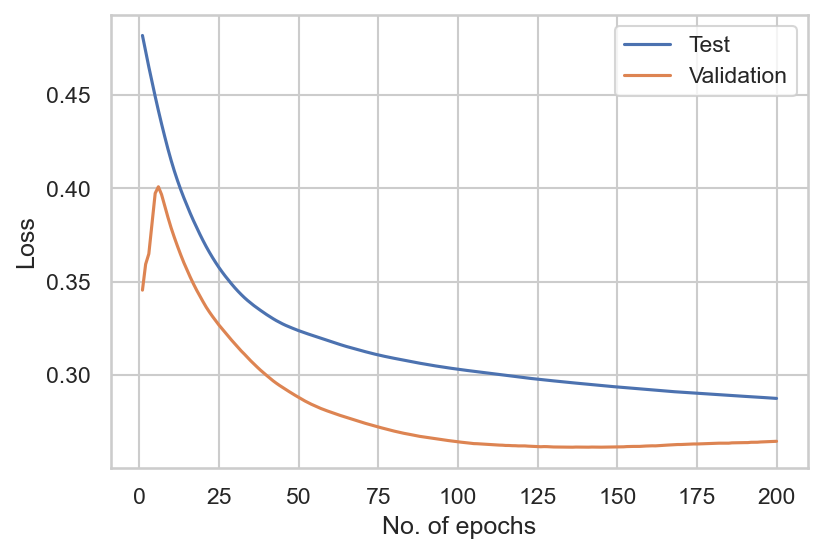

In [11]:
all_test_loss = []
all_val_loss = []
total_iter = 0

for epoch in range(num_epochs):
    forecast_model.train()
    
    
    for i, (X_data, y_data) in enumerate(train_loader):
        for j, (mask) in enumerate(mask_loader):
            if j != i: continue
            break
    
        optimizer.zero_grad()

        X_data = X_data.cuda().float()
        y_data = y_data.cuda().float()

        y_mask = mask.cuda().float()
        
        
        y_pred = forecast_model(X_data)
        loss = criterion(y_data, y_pred, y_mask)
        
        total_iter += 1
        writer.add_scalar("Loss/train", loss, total_iter)
        
        loss.backward()
        optimizer.step()
        
    if (epoch +1) % 50 == 0:
        print (f'Train loss after Epoch [{epoch+1}/{num_epochs}]: {loss.item():.6f}')
    
    all_test_loss.append(loss.item())
    
    
    forecast_model.eval()
    
    with torch.no_grad():
        val_pred = forecast_model(X_val).cuda()
        val_loss = criterion(y_val, val_pred, mask_val)
        all_val_loss.append(val_loss.item())
        

plt.plot(list(range(1, num_epochs + 1)), all_test_loss, label = 'Test')
plt.plot(list(range(1, num_epochs + 1)), all_val_loss, label = 'Validation')
plt.legend(loc="upper right")
plt.xlabel('No. of epochs')
plt.ylabel('Loss')

In [13]:
with torch.no_grad():
    forecast_model.eval()
    predicted_outputs = forecast_model(X_test).cuda()
    test_loss = criterion(y_test, predicted_outputs, mask_test)
    print(test_loss.item())

0.2670694887638092
